In [1]:
%pylab inline
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


In [2]:
counts = pd.read_csv('~/Google Drive/Research Projects/Finished/Power-analysis/Public data/GSE60768/GSE60768_umi_counts.csv', index_col=0)
counts = counts.astype(int)

sample_info = pd.DataFrame({'condition': counts.columns.str.split('_').str.get(1)}, index=counts.columns)

sample_info['total_counts'] = counts.sum()
sample_info['num_genes'] = (counts > 0).sum()
sample_info['ERCC'] = counts[counts.index.str.startswith('ERCC-')].sum()

In [3]:
import NaiveDE

In [5]:
exp_mat = NaiveDE.stabilize(counts)

In [33]:
sample_info['is_nsc'] = (sample_info['condition'] == 'NSC')

In [52]:
results = NaiveDE.lr_tests(sample_info, exp_mat, '~ is_nsc')

In [53]:
results.query('qval < 0.05').sort_values('is_nsc[T.True]', ascending=False).head()

,Intercept,is_nsc[T.True],pval,qval
ENSMUSG00000019874,-0.527953,1.689516,2.452534e-29,3.531649e-27
ENSMUSG00000001270,0.420139,1.678662,1.662159e-15,2.393509e-13
ENSMUSG00000017390,-0.348674,1.318489,1.601736e-20,2.306500e-18
ENSMUSG00000064345,1.717341,1.125318,1.045922e-05,1.506128e-03
ENSMUSG00000027523,0.239607,1.112670,6.673045e-11,9.609185e-09


In [54]:
results.query('qval < 0.05').sort_values('is_nsc[T.True]', ascending=True).head()

,Intercept,is_nsc[T.True],pval,qval
ENSMUSG00000060461,2.463119,-3.001469,1.138069e-20,1.638819e-18
ENSMUSG00000052551,1.710377,-2.248727,5.308468e-19,7.644194e-17
ENSMUSG00000049422,1.552164,-2.090515,4.939452e-18,7.112811e-16
ENSMUSG00000031762,1.406679,-1.924235,9.565416e-14,1.377420e-11
ENSMUSG00000004951,1.330391,-1.847947,6.491781e-17,9.348164e-15


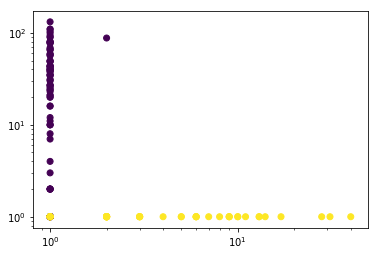

In [58]:
plt.loglog();
plt.scatter(counts.loc['ENSMUSG00000019874'] + 1, counts.loc['ENSMUSG00000060461'] + 1, c=sample_info.is_nsc);

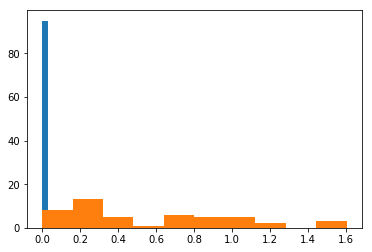

In [68]:
for i, g in sample_info.groupby('is_nsc'):
    plt.hist(np.log10(counts[g.index].loc['ENSMUSG00000019874'] + 1));

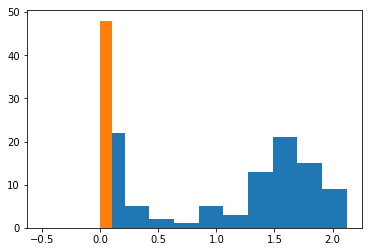

In [69]:
for i, g in sample_info.groupby('is_nsc'):
    plt.hist(np.log10(counts[g.index].loc['ENSMUSG00000060461'] + 1));

In [156]:
import pickle

with open('poisson_mixtures.pkl', 'rb') as fh:
    model = pickle.load(fh)
    


In [202]:
idx = counts.pipe(np.log1p).var(1).sort_values(ascending=False).head(100).index

In [224]:
idx_s = np.random.choice(idx, 10, replace=False)

In [225]:
N = sample_info.shape[0]
y = counts.loc[idx_s].values.T

data = {
    'K': 2,
    'N': N,
    'G': y.shape[1],
    'y': y
}

In [226]:
v = model.vb(data=data, iter=1000)

In [227]:
res = pd.read_csv(v['args']['sample_file'].decode('ascii'), comment='#').dropna()
resm = res.mean()

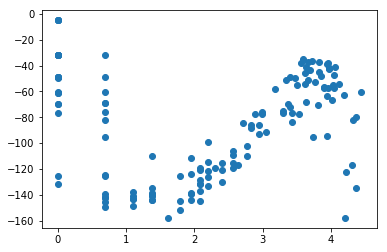

In [228]:
log_p_y = resm[resm.index.str.startswith('log_p_y')]
plt.scatter(np.log(y + 1)[:,1], log_p_y)

In [229]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

In [230]:
YY = pca.fit_transform(exp_mat.T[idx])

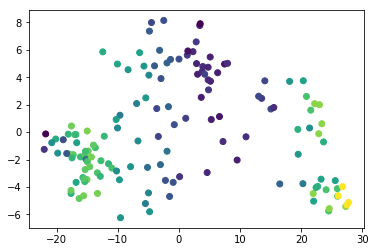

In [231]:
plt.scatter(*YY.T, c= log_p_y);